# Notebook Objectives
- Load data
- Re-order columns
- Add time encoding
- Separate weekday from weekend
- Explore sensor correlations
- Rescale/normalize
- Build sliding window representation 

In [3]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
import time
import os

In [4]:
dataset = pd.read_csv( index_col = 0,  parse_dates = True, infer_datetime_format = True, 
                         filepath_or_buffer = './data/2018-01-01__2019-01-01__NConservatory__allMerged.csv')

In [5]:
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_convert('America/Los_Angeles')

# Re-order columns [ facilitates cross-correlation analysis ]

In [6]:
orderedSensorList = ( 'co2_1','co2_2', 'co2_3', 'co2_4',                        
                      'temp_1', 'temp_2', 'temp_3', 'temp_4',                     
                      'dew_1','dew_2', 'dew_3', 'dew_4',
                      'relH_1', 'relH_2', 'relH_3', 'relH_4',
                      'externTemp_1', 
                      'externHumid_1', 
                      'externSunrise_1',                      
                      'externCondition_1' )        

In [7]:
orderedDataset = dataset.reindex( index = dataset.index, columns = orderedSensorList )

In [8]:
orderedDataset.shape

(34934, 20)

In [9]:
orderedDataset.head().T

,2018-01-01 00:00:03-08:00,2018-01-01 00:15:03-08:00,2018-01-01 00:30:03-08:00,2018-01-01 00:45:03-08:00,2018-01-01 01:00:03-08:00
co2_1,480.750000,480.750000,477.817993,486.612000,486.612000
co2_2,474.886993,474.886993,477.817993,477.817993,474.886993
co2_3,477.817993,474.886993,474.886993,474.886993,477.817993
co2_4,474.886993,474.886993,474.886993,477.817993,477.817993
temp_1,59.400002,59.200001,59.099998,58.900002,58.799999
temp_2,60.000000,59.799999,59.700001,59.400002,59.200001
temp_3,58.799999,58.500000,58.299999,58.000000,57.799999
temp_4,58.500000,58.299999,58.000000,57.799999,57.700001
dew_1,52.214100,52.389801,52.214100,52.038300,51.862499
dew_2,51.510899,51.686699,51.510899,51.335201,51.335201


# Plot 2018 Data

In [10]:
plt.rcParams['figure.figsize'] = [ 20, 15 ] 
plt.rcParams['figure.subplot.left'] = plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.right'] = plt.rcParams['figure.subplot.top'] = .9

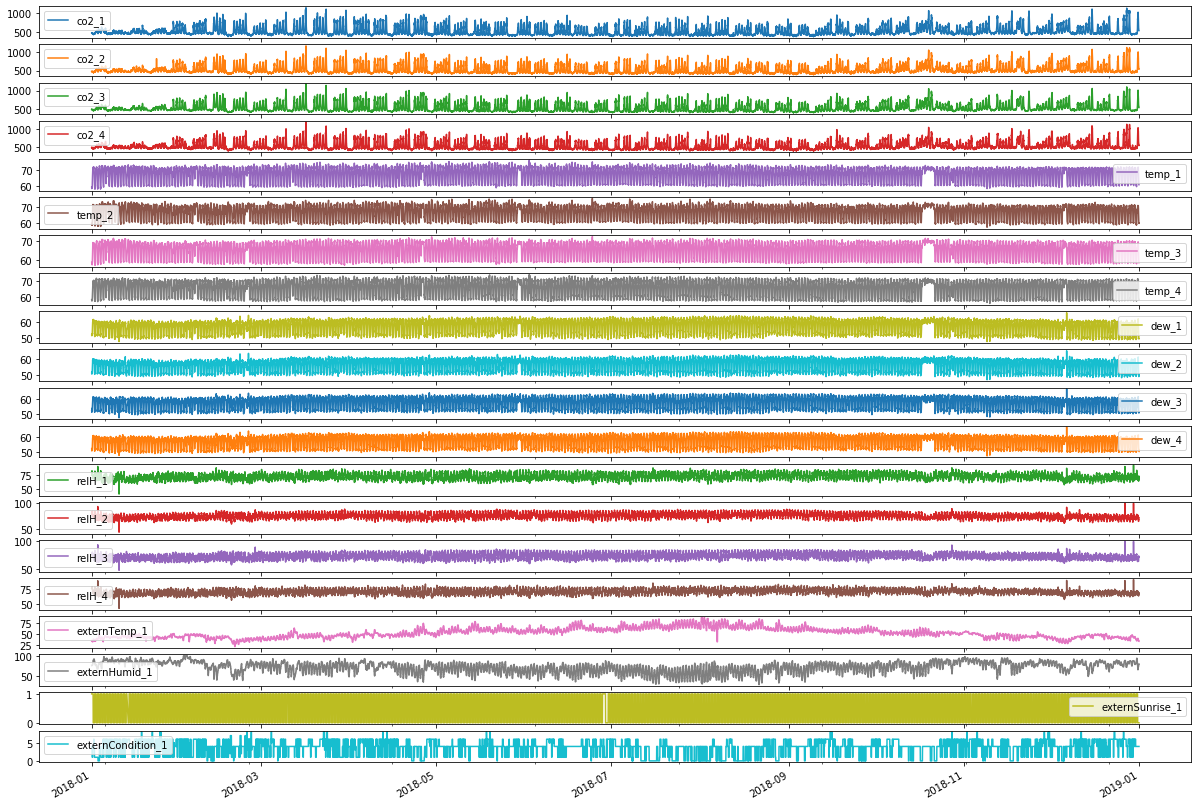

In [11]:
orderedDataset.plot( subplots = True );

# Separate Week from Weekend

### Add time encoding/reference (day and hour)

In [12]:
dayIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.dayofweek/6, decimals=2), 
                       name='dayIndex')
hourIndexDF = pd.Series(index = orderedDataset.index, 
                       data = np.round(orderedDataset.index.hour/24, decimals=2), 
                       name='hourIndex')

In [13]:
orderedDatasetTimeReference = pd.concat([orderedDataset, hourIndexDF, dayIndexDF], axis=1)

In [14]:
orderedDatasetTimeReference["dayIndex"].index

DatetimeIndex(['2018-01-01 00:00:03-08:00', '2018-01-01 00:15:03-08:00',
               '2018-01-01 00:30:03-08:00', '2018-01-01 00:45:03-08:00',
               '2018-01-01 01:00:03-08:00', '2018-01-01 01:15:03-08:00',
               '2018-01-01 01:30:03-08:00', '2018-01-01 01:45:03-08:00',
               '2018-01-01 02:00:03-08:00', '2018-01-01 02:15:03-08:00',
               ...
               '2018-12-31 21:44:52-08:00', '2018-12-31 21:59:52-08:00',
               '2018-12-31 22:14:52-08:00', '2018-12-31 22:29:52-08:00',
               '2018-12-31 22:44:52-08:00', '2018-12-31 22:59:52-08:00',
               '2018-12-31 23:14:52-08:00', '2018-12-31 23:29:52-08:00',
               '2018-12-31 23:44:52-08:00', '2018-12-31 23:59:52-08:00'],
              dtype='datetime64[ns, America/Los_Angeles]', length=34934, freq=None)

In [15]:
saturdayVal = np.round(5/6,decimals=2)
sundayVal = np.round(6/6,decimals=2)

In [16]:
weekdayData = orderedDatasetTimeReference[ ( dayIndexDF != saturdayVal) &( dayIndexDF != sundayVal) ]

In [17]:
weekendData = orderedDatasetTimeReference[ ( dayIndexDF == saturdayVal) | (dayIndexDF == sundayVal) ]

In [18]:
weekdayData.shape, weekendData.shape

((25033, 22), (9901, 22))

# Explore Weekday and Weekend Sensor Cross-Correlations

In [19]:
xCorrWeekday = weekdayData.corr()
xCorrWeekend = weekendData.corr()

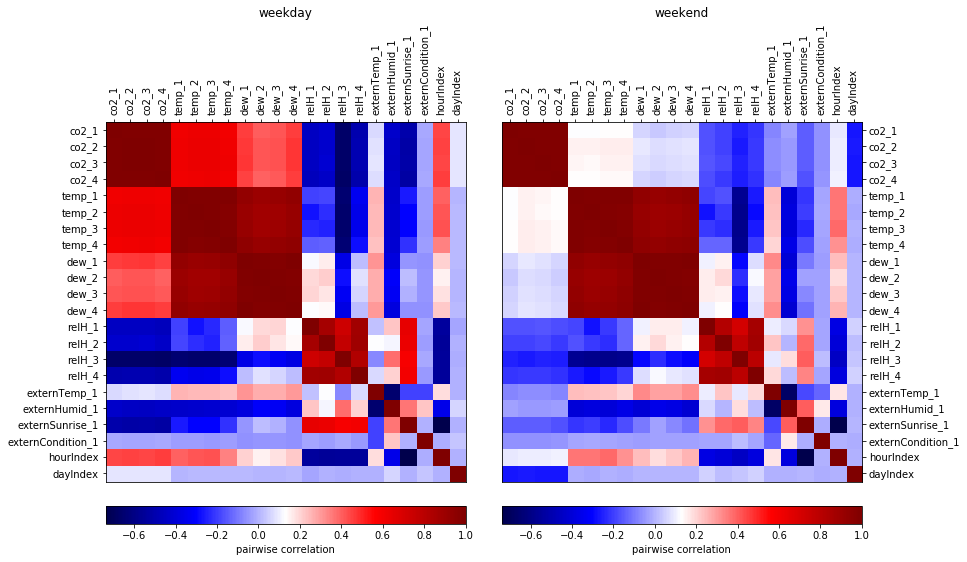

In [20]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05, wspace=.1)

ax1 = plt.subplot(1,2,1)
im1 = plt.imshow(xCorrWeekday, cmap = plt.get_cmap('seismic'))
plt.xticks(range(0,len(xCorrWeekday)), labels=weekdayData.columns, rotation = 90)
plt.yticks(range(0,len(xCorrWeekday)), labels=weekdayData.columns)
plt.title('weekday')
ax1.xaxis.tick_top()

ax2 = plt.subplot(1,2,2)
im2 = plt.imshow(xCorrWeekend, cmap = plt.get_cmap('seismic'))
plt.xticks(range(0,len(xCorrWeekend)), labels=weekendData.columns, rotation = 90)
plt.yticks(range(0,len(xCorrWeekend)), labels=weekendData.columns)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
plt.title('weekend')

fig.colorbar(im1, ax=ax1, label='pairwise correlation', orientation='horizontal', pad=.025)
fig.colorbar(im2, ax=ax2, label='pairwise correlation', orientation='horizontal', pad=.025)
plt.show()

# Rescale/Normalize [ focus on weekday data ]

In [21]:
continuousData = weekdayData.values[:, 0:17] # first 17 sensors are continuous valued
categoricalData = weekdayData.values[:, 17:]

standardScaler = StandardScaler()
standardScaler.fit( continuousData )

minMaxScaler = MinMaxScaler()
minMaxScaler.fit( categoricalData )

scaledContinuousData = standardScaler.transform(continuousData)
scaledCategoricalData = minMaxScaler.transform(categoricalData)

weekdayData_scaled =  pd.DataFrame( index = weekdayData.index,
                                    data = np.hstack( (scaledContinuousData, scaledCategoricalData)),
                                    columns = weekdayData.columns)

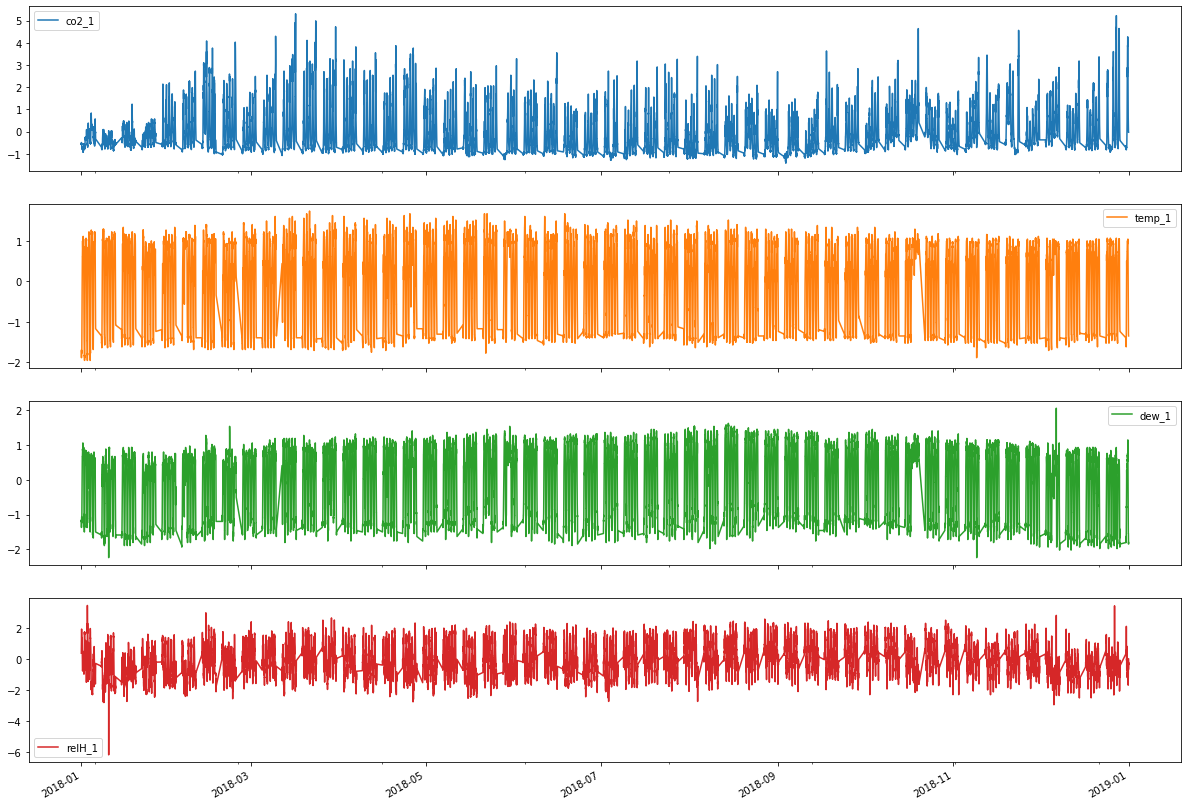

In [22]:
weekdayData_scaled[['co2_1', 'temp_1', 'dew_1', 'relH_1']].plot(subplots=True);

# Convert to Sliding Window Representation


In [23]:
def build_train_data ( inputDataframe, outputFilename, advanceTimedeltaStr = '15 min' ):

    npFilename = outputFilename + '.npy'
    npFilenameSamplebounds = outputFilename + '_sampleBounds' + '.npy'
    rebuildFlag = True # flips if file exists in cache and user agrees to restore

    windowCounter = correctLenWindows = fixedWindows = 1
    trimNeededWindows = extensionNeededWindows = 1
    sumExtensionAmount = sumTrimAmount = 0
    
    def extract_one_day( startTime, endTime, idealIndex, nExtensionAttempts=10 ):        
        nonlocal correctLenWindows, trimNeededWindows, extensionNeededWindows, \
                sumExtensionAmount, sumTrimAmount, fixedWindows

        oneDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                         & (inputDataframe.index < endTime)]
        
        if len(oneDay) == len(idealIndex):
            correctLenWindows += 1

        # available data in day range is too long -- trimming required
        if len(oneDay) > len(idealIndex):
            trimNeededWindows += 1
            sumTrimAmount += len(oneDay) - len(idealIndex)
            oneDay = oneDay.iloc[0:len(idealIndex)]
        
        # available data in day range is of insufficient length -- extension required 
        if len(oneDay) < len(idealIndex):
            extensionNeededWindows += 1
            sumExtensionAmount += len(idealIndex) - len(oneDay)
            
            oneDay = None
            # attempt to extend one sample at a time up to nExtensionAttempts
            for iExtensionAttempt in range( nExtensionAttempts ):
                endTime += pd.Timedelta( advanceTimedeltaStr)
                extendedDay = inputDataframe[ (inputDataframe.index >= startTime) \
                                                 & (inputDataframe.index < endTime)]
                # sucessfully extened data slice
                if len( extendedDay) == len( idealIndex ):
                    fixedWindows += 1
                    oneDay = extendedDay
                    break
        
        # only happens when available data requires extension beyond nExtensionAttempts
        if oneDay is None:
            return None, None, None
        
        assert ( len(oneDay) == len(idealIndex) )
        return oneDay.values.reshape(1,-1, order = 'F'), oneDay.index[0], oneDay.index[-1]
    
    
    # check cache
    if Path(npFilename).is_file() and Path(npFilenameSamplebounds).is_file():
        print('created on: {} \n\t size: {} MB'.format( time.ctime(os.path.getctime(npFilename)), 
                                                        Path(npFilename).stat().st_size / 1e6 ))
        if 'y' == input('load from cache? (y/n): '):
            npTrainMatrix = np.load(npFilename, allow_pickle=True) # load from cache
            sampleIndexBounds = np.load(npFilenameSamplebounds, allow_pickle=True)
            rebuildFlag = False
    
    if rebuildFlag:
        npTrainMatrix = None
        sampleIndexBounds = None
        npTestMatrix = None

        startTime = inputDataframe.index[0]
        while(1):
            endTime = startTime + pd.Timedelta('1 day');
            
            # terminate window extraction once end of dataset is reached
            if startTime > inputDataframe.index[-1] or endTime > inputDataframe.index[-1]:
                break
            
            # generate an ideal index [ 96 x 15 min samples from current startTime ]
            idealIndex = pd.date_range(start=startTime, end=endTime, freq='15T', closed='left' );
            
            # ensure that current window is a weekday
            if (idealIndex.dayofweek < 5).all():
                
                # gather data from sensor streams going one day forward
                dataWindow, windowStartIndex, windowEndIndex = \
                    extract_one_day ( startTime, endTime, idealIndex)
                
                # dataWindow is none only when more than ~10 samples are missing                
                if dataWindow is not None:                
                    windowCounter += 1
                    
                    # first iteration is a direct assignment, all others require appending 
                    if npTrainMatrix is None:
                        npTrainMatrix = dataWindow;
                        sampleIndexBounds = np.array([windowStartIndex, windowEndIndex]);
                    else:
                        assert( dataWindow.shape[1] == npTrainMatrix.shape[1] ) # import ipdb; ipdb.set_trace()
                        npTrainMatrix = np.append( npTrainMatrix, dataWindow, axis = 0 );
                        sampleIndexBounds = np.append( sampleIndexBounds, 
                                                       np.array([windowStartIndex, windowEndIndex]) , axis = 0);
                        
            else:
                pass # skipping -- day segment includes a piece of the weekend
            
            avgTrim = np.round(sumTrimAmount/trimNeededWindows, decimals=2);
            avgExtend = np.round(sumExtensionAmount/extensionNeededWindows, decimals=2);
            
            # advance to next sample
            startTime = startTime + pd.Timedelta(advanceTimedeltaStr);

        print('nWindows {} - nCorrect {}; nTrimNeeded {} | avg.trim {}; nExtendNeeded {} | avg.ext {} | fixedViaExtension {}'.format(windowCounter, correctLenWindows, 
                       trimNeededWindows, avgTrim, extensionNeededWindows, avgExtend, fixedWindows), end='\r')

        print('\nwriting to cache')
        
        # save to cache
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        np.save(npFilename, npTrainMatrix)
        np.save(npFilenameSamplebounds, sampleIndexBounds)

    if sampleIndexBounds.shape[0] != npTrainMatrix.shape[0]:
        sampleIndexBounds = sampleIndexBounds.reshape(npTrainMatrix.shape[0], -1)
        
    return npTrainMatrix, sampleIndexBounds

In [26]:
%%time
outputFilename = './data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef'
npTrainMatrix, sampleIndexBounds = build_train_data ( weekdayData_scaled, outputFilename )

created on: Sun Aug  2 16:51:55 2020 
	 size: 338.0384 MB


load from cache? (y/n):  y


CPU times: user 329 ms, sys: 129 ms, total: 458 ms
Wall time: 5.18 s


In [123]:
len(weekdayData_scaled)

25033

In [27]:
npTrainMatrix.shape

(20007, 2112)

# Plot Sliding Windows

In [28]:
samplesInADay = 96 # 96 samples 15 minutes apart = 24 hours 

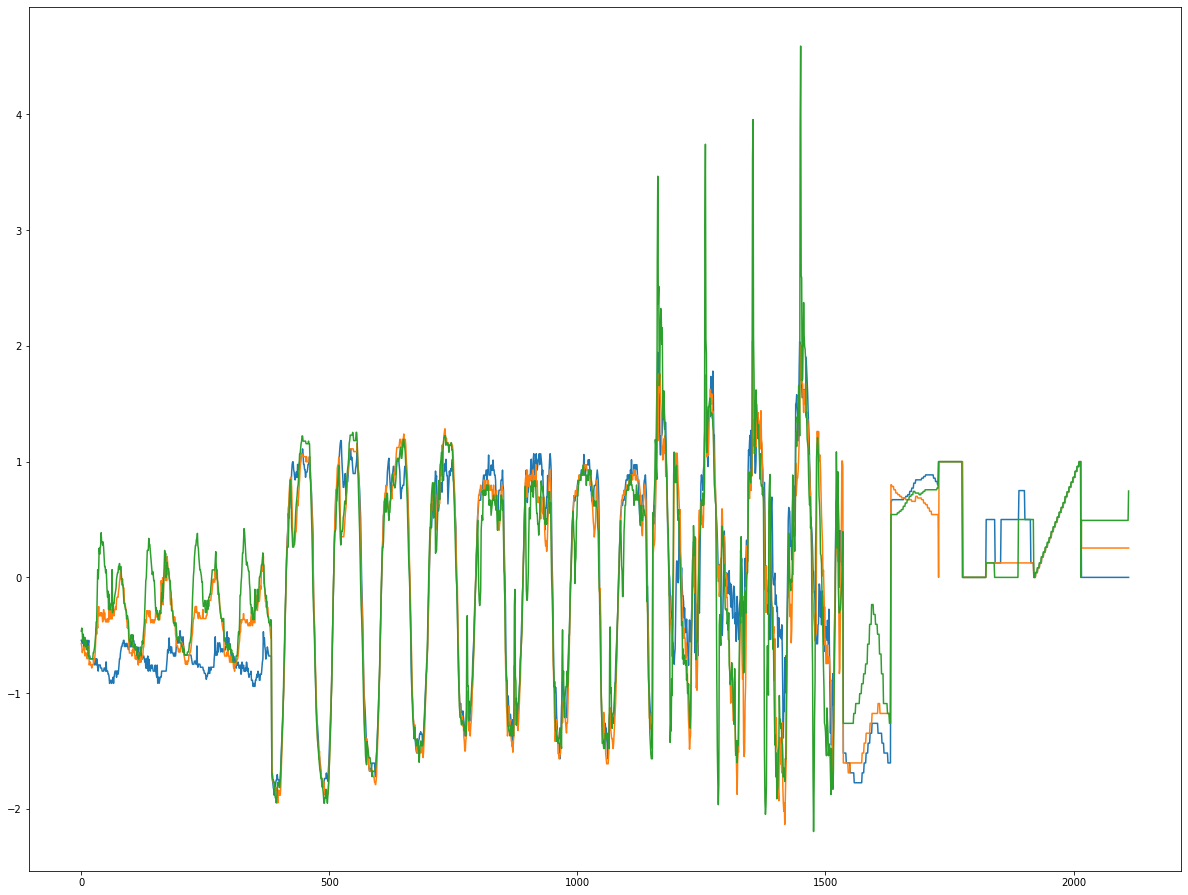

In [29]:
nSlidingWindowsToPlot = 3
plt.figure()
for iDay in range(nSlidingWindowsToPlot):
    startIndex = (iDay) * samplesInADay
    plt.plot(npTrainMatrix[startIndex,:])

In [30]:
npTrainMatrix.shape

(20007, 2112)

In [31]:
weekdayData_scaled.describe()

,co2_1,co2_2,co2_3,co2_4,temp_1,temp_2,temp_3,temp_4,dew_1,dew_2,...,relH_1,relH_2,relH_3,relH_4,externTemp_1,externHumid_1,externSunrise_1,externCondition_1,hourIndex,dayIndex
count,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,...,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,2.503300e+04,25033.000000,25033.000000,25033.000000,25033.000000,25033.000000
mean,1.196934e-15,7.457095e-15,-1.736892e-15,1.801460e-16,-9.889957e-16,-1.467288e-16,1.124743e-15,8.284651e-17,3.091328e-15,1.021620e-15,...,-1.177728e-15,2.017308e-15,9.517813e-17,3.202789e-15,-1.666457e-15,0.597962,0.500979,0.453192,0.498262,0.496666
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,...,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,0.192983,0.500009,0.259937,0.301174,0.353326
min,-1.421144e+00,-1.383592e+00,-1.354581e+00,-1.439776e+00,-1.949674e+00,-2.093881e+00,-1.791443e+00,-1.699033e+00,-2.237622e+00,-2.401741e+00,...,-6.153357e+00,-6.620643e+00,-4.837243e+00,-6.947258e+00,-2.715632e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.423146e-01,-7.436227e-01,-7.356788e-01,-7.320949e-01,-1.056230e+00,-1.025656e+00,-1.138706e+00,-1.090243e+00,-1.067103e+00,-1.088701e+00,...,-7.676851e-01,-7.280813e-01,-8.173079e-01,-7.449387e-01,-7.479427e-01,0.471429,0.000000,0.125000,0.218750,0.253731
50%,-3.581802e-01,-3.667208e-01,-3.558209e-01,-3.520836e-01,2.839357e-01,2.799520e-01,3.299538e-01,2.693879e-01,3.635090e-01,3.650111e-01,...,-1.437607e-02,-1.039845e-02,-1.189099e-02,-2.369661e-02,-1.490807e-01,0.628571,1.000000,0.500000,0.479167,0.492537
75%,5.187722e-01,5.197907e-01,5.115231e-01,5.259996e-01,9.316808e-01,9.446262e-01,9.127551e-01,9.796429e-01,8.837455e-01,8.808217e-01,...,7.231972e-01,6.882677e-01,7.835928e-01,7.415991e-01,7.064365e-01,0.742857,1.000000,0.750000,0.739583,0.746269
max,5.302129e+00,5.604175e+00,5.768131e+00,5.925363e+00,1.735781e+00,1.822944e+00,1.612117e+00,1.649312e+00,2.054264e+00,2.428332e+00,...,3.466194e+00,5.039956e+00,5.120257e+00,4.734749e+00,3.016333e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [141]:
weekdayData_scaled.columns

Index(['co2_1', 'co2_2', 'co2_3', 'co2_4', 'temp_1', 'temp_2', 'temp_3',
       'temp_4', 'dew_1', 'dew_2', 'dew_3', 'dew_4', 'relH_1', 'relH_2',
       'relH_3', 'relH_4', 'externTemp_1', 'externHumid_1', 'externSunrise_1',
       'externCondition_1', 'hourIndex', 'dayIndex'],
      dtype='object')

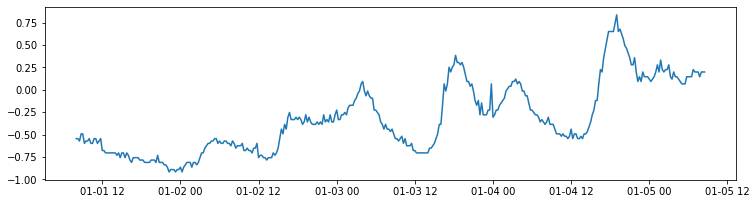

In [145]:
plt.figure(figsize=(12,3))
plt.plot(weekdayData_scaled['co2_1'][96*0:96*4])

# Split train/val/test data

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [147]:
n = len(npTrainMatrix)

In [148]:
X_train = npTrainMatrix[:int(n*0.75), :]
X_test = npTrainMatrix[int(n*0.75):, :]

In [149]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

In [150]:
dataLoaderTrain = DataLoader( X_train.astype('float32'), 
                              batch_size = 128, 
                              shuffle = True ) # could adjust batch size

dataLoaderTest = DataLoader( X_test.astype('float32'), 
                             batch_size = 1, 
                             shuffle = False )

In [152]:
inputDimensionality = X_train.shape[1]

model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid(),
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

In [153]:
targetDevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Model

In [154]:
def train_model ( model, dataLoader, targeDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
#     lossFunction = nn.MSELoss()
    lossFunction = nn.L1Loss()
    optimizer = torch.optim.Adam( model.parameters(),  lr=1e-3)
    lossHistory = []
    history = dict(train=[], val=[])
    batchLoss = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            batchLoss.append(loss.item())
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory, batchLoss

In [155]:
startTime = time.time()

model, lossHistory, batchLoss = train_model( model, dataLoaderTrain, targetDevice, nEpochs = 10 )

print('elapsed time : {} '.format(time.time() - startTime))

epoch 0 of 10 -- avg batch loss: 70.07839643955231
epoch 1 of 10 -- avg batch loss: 37.53932189941406
epoch 2 of 10 -- avg batch loss: 33.43879435956478
epoch 3 of 10 -- avg batch loss: 29.321179568767548
epoch 4 of 10 -- avg batch loss: 28.32046176493168
epoch 5 of 10 -- avg batch loss: 27.755661964416504
epoch 6 of 10 -- avg batch loss: 27.23649075627327
epoch 7 of 10 -- avg batch loss: 26.752577424049377
epoch 8 of 10 -- avg batch loss: 26.35649187862873
epoch 9 of 10 -- avg batch loss: 25.988339334726334
elapsed time : 65.56731104850769 


### Visualize Progression of Learning

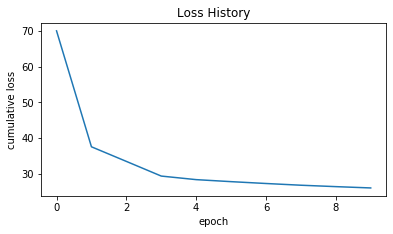

In [156]:
plt.figure(figsize=(6,3))
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

# Evaluate Model Performance

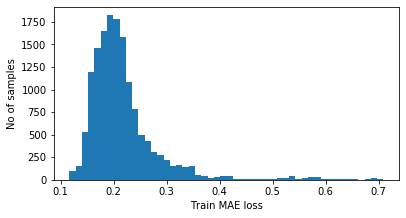

Reconstruction error threshold:  0.5588932204246503
Number of anomaly samples:  151


In [157]:
# Get train MAE loss.
trainingData = X_train.astype(np.float32)
x_train_pred = model.forward(torch.from_numpy(trainingData))
train_mae_loss = np.mean(np.abs(trainingData - x_train_pred.detach().numpy()),axis = 1)

plt.figure(figsize=(6,3)) 
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.quantile(train_mae_loss,0.99)
print("Reconstruction error threshold: ", threshold)

# Detect all the samples which are anomalies.
anomalies = (train_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))

In [77]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] contain anomalies
anomalous_data_indices = []
TIME_STEPS = 96
test_value = X_test
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if any([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [78]:
len(anomalous_data_indices)

105

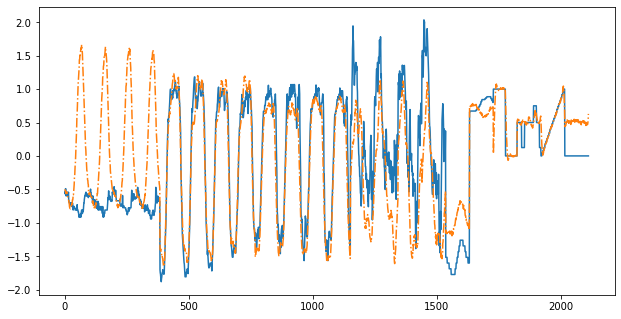

In [140]:
plt.figure(figsize=(10,5))
plt.plot(X_train[0,:].reshape(-1,1))
plt.plot(x_train_pred[0,:].reshape(-1,1).detach().numpy(),'-.')

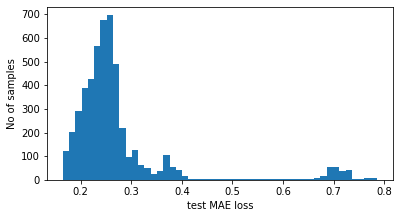

Number of anomaly samples:  263


In [81]:
# Get test MAE loss.
# x_test_pred = model.predict(x_test)
testingData = X_test.astype(np.float32)
x_test_pred = model.forward(torch.from_numpy(testingData))

test_mae_loss = np.mean(np.abs(testingData - x_test_pred.detach().numpy()), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.figure(figsize=(6,3)) 
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))

In [82]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
TIME_STEPS = 96
test_value=X_test
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [139]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 3):

    for iSample in range(nEvals):

        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )

        plt.figure(figsize=(18,10))
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
        ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

        ax1.plot(sampleNumpy)
        ax1.plot(reconstructionNumpy, '-.')
        ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
        ax1.legend(['input data', 'reconstruction'])

        ax2.plot(error)
        ax2.legend( ['reconstruction error'] )


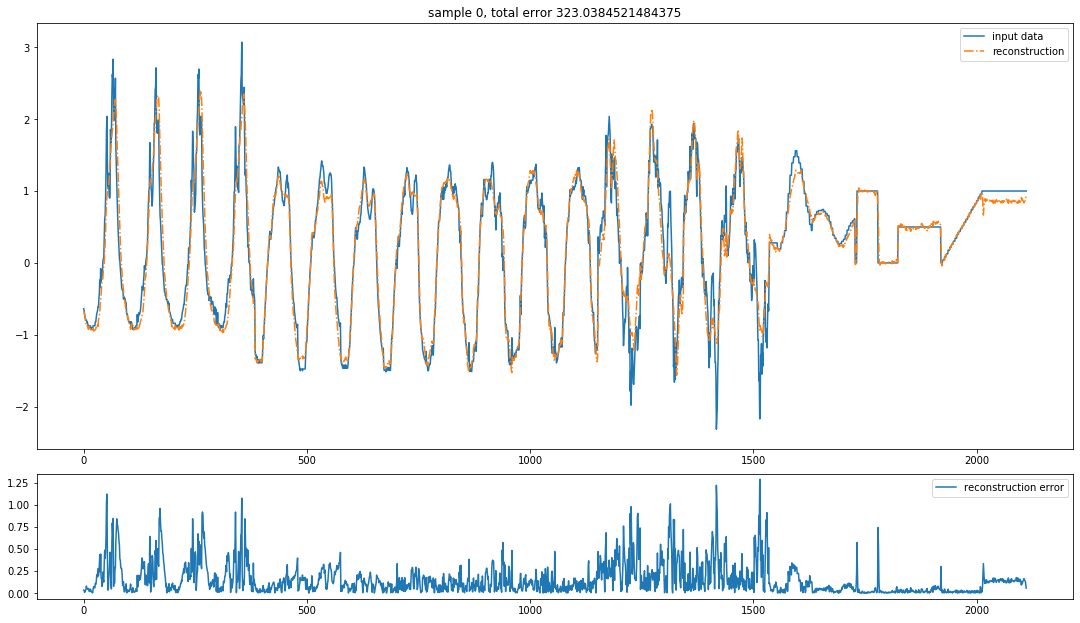

In [135]:
evaluate_model( model, dataLoaderTest, targetDevice , 1)

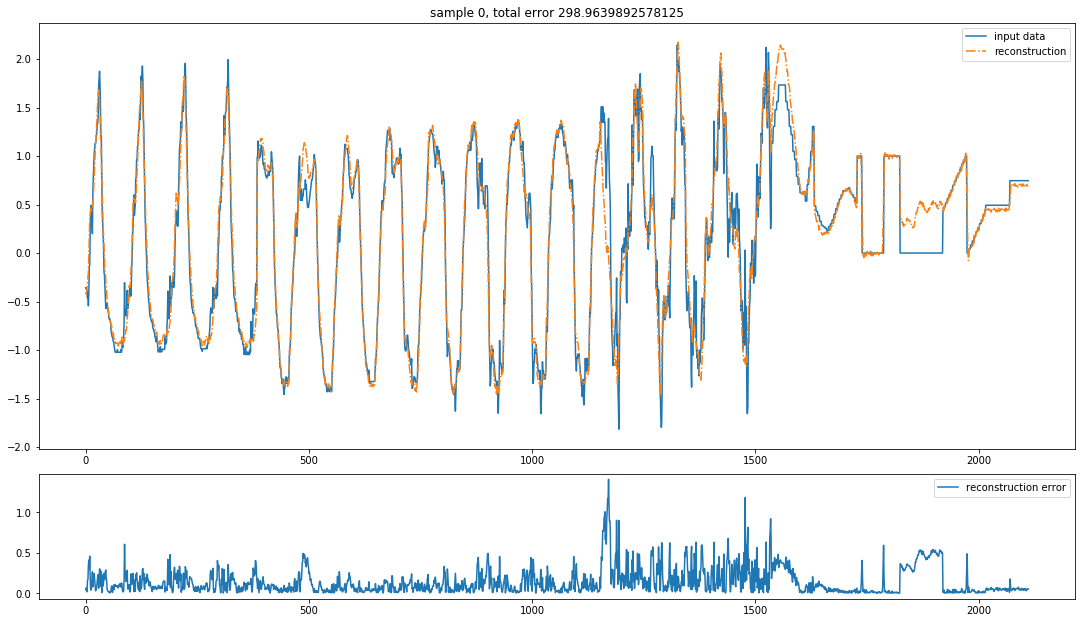

In [138]:
evaluate_model( model, dataLoaderTrain, targetDevice , 1)